In this plot, I want to make a plot summarizing the large spectroscopic dwarf galaxy surveys we have available and where DESI lies in this space ...

Inspired by the SAGA survey plot

In [1]:
import os
import sys
import glob
import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, match_c_to_catalog, print_radecs
from desi_lowz_funcs import calc_normalized_dist
from desi_lowz_funcs import find_objects_nearby
from construct_dwarf_galaxy_catalogs import process_sga_matches


Make a slice plot focusing on the patch where DESI is really complete and do something there!

In [2]:

# Path to the catalog
filename = "/pscratch/sd/v/virajvm/desi_dwarf_catalogs/dr1/v1.0/desi_dr1_dwarf_catalog.fits"

# Option 1: load the MAIN extension directly as an Astropy Table
main = Table.read(filename, hdu="MAIN")

# Option 2: load the FASTSPEC extension
fastspec = Table.read(filename, hdu="FASTSPEC")




In [3]:
main["comov_dist"] = Planck18.comoving_distance(main["Z_CMB"]).data


In [7]:
tot_cat = main.copy()

Select some TGIDS whose spectra to display at different redshifts

BGSB =  39627322709513192
BGSF = 39627345413284126
LOWZ = 2705974209019904
ELG = 39627357518039557


In [ ]:
rmag_bins = np.arange(18,24,1)

rmag_bins

In [ ]:

for i in range(1,2):
    rmag_min = rmag_bins[i]
    rmag_max = rmag_bins[i+1]
    
    zred_mask = (tot_cat["LOGM_SAGA"] < 7.6) & (tot_cat["LOGM_SAGA"] > 7.4) & (tot_cat["MAG_R"] > rmag_min) & (tot_cat["MAG_R"] < rmag_max) & (tot_cat["SAMPLE"] == "BGS_FAINT")

    temp = tot_cat[zred_mask]
    for i in range(10):
        print(f"https://www.legacysurvey.org/viewer-desi/desi-spectrum/dr1/targetid{temp['TARGETID'][i]}")
    
    print("----")
    
# # bgsf_zred_mask = (tot_cat["LOGM_SAGA"] < 7.6) & (tot_cat["LOGM_SAGA"] > 7.4) & (tot_cat["SAMPLE"] == "BGS_FAINT") 
# # lowz_zred_mask = (tot_cat["LOGM_SAGA"] < 7.6) & (tot_cat["LOGM_SAGA"] > 7.4) & (tot_cat["SAMPLE"] == "LOWZ") 
# # elg_zred_mask = (tot_cat["LOGM_SAGA"] < 7.6) & (tot_cat["LOGM_SAGA"] > 7.4) & (tot_cat["SAMPLE"] == "ELG") 


In [ ]:
eg_tgids = [39627427021851828, 39627491345697115, 2705980336898048, 39627555304643301, 39627391634506945]

In [ ]:
sample_color_map = {"BGS_BRIGHT" : "#882255", "BGS_FAINT": "#CC6677", "LOWZ":"#DDCC77", "ELG": "#88CCEE" }


In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MaxNLocator

def make_spectra_panel(tgids_interest, tot_cat,wave_min=3400, wave_max = 9800, save_folder = "/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_spectra/example_spec/"):
    
    fig, ax = plt.subplots(len(tgids_interest), 1, figsize=(15, int(3*len(tgids_interest)) ),sharex=True)
    plt.subplots_adjust(hspace = 0.1)

    for i in range(len(tgids_interest)):
    
        result = np.load(save_folder + f"spec_{tgids_interest[i]}.npz")
        
        fluxs = result["flux"]
        waves = result["wave"]
        ivar = result["ivar"]
        rgb_img = result["image"]
        mag_r = result["mag_r"]
        dchi2 = result["dchi2"]
        tgid = result["tgid"]
        zred = result["zred"]

        samp_i = tot_cat[tot_cat["TARGETID"] == tgid]["SAMPLE"][0]

        waves = waves/(1+zred)
        
        # Main spectrum plotting
        ax[i].plot(waves, fluxs, color='grey', alpha=0.15, lw=1)

        flux_smooth = convolve(fluxs, Gaussian1DKernel(5))[5:-5]

        ax[i].plot(waves[5:-5], flux_smooth , color=sample_color_map[samp_i], lw=2)
        
        ax[i].set_xlim([wave_min, wave_max])
        ax[i].tick_params(axis='both', labelsize=17)
        ax[i].set_ylim([-0.5, np.max(flux_smooth) * 1.3])
        tick_vals = np.linspace(-0.5, np.max(flux_smooth) * 1.125, 3).astype(int)
        ax[i].set_yticks(tick_vals)

        if i == len(tgids_interest) - 1:
            ax[i].set_xlabel('Rest-Frame Wavelength [$\\AA$]', fontsize=17)
            
        # ax[i].set_ylabel('$F_{\\lambda}$ [$10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$]', fontsize=15)
        # ax[i].yaxis.set_major_locator(MaxNLocator(integer=True))
        # Add inset axes in top-right
        inset_ax = inset_axes(ax[i], width=1.5, height=1.5, 
                        bbox_to_anchor=(0.85, 0.15, 0.4, 0.4),  # (x0, y0, width, height) in axes fraction
                      bbox_transform=ax[i].transAxes,
                      loc='lower left')  # position inside the bbox
        
        cut = 5
        inset_ax.imshow(rgb_img[cut:-cut,cut:-cut,:],origin="lower")
        inset_ax.set_title(f"{tgid}",fontsize = 11)
        inset_ax.axis('off')  # Hide axis ticks and frame
        # inset_ax.text(0.5, 0.95,"(%.3f,%.3f, z=%.3f)"%(temp["RA"][0],temp["DEC"][0], temp["Z"][0]) ,color = "white",fontsize = 9.25,
        #                   transform=inset_ax.transAxes, ha = "center", verticalalignment='top')

        inset_ax.text(0.5, 0.95,"z=%.3f"%(zred) ,color = "white",fontsize = 18,
                          transform=inset_ax.transAxes, ha = "center", verticalalignment='top')
        
        inset_ax.text(0.5, 0.18,"$\Delta\chi^2$=%.0f"%(dchi2) ,color = "white",fontsize = 12,
                          transform=inset_ax.transAxes, ha = "center", verticalalignment='top')

        ax[i].text(0.65,0.9, r"r-band mag = %.1f"%(mag_r), fontsize = 17.5,
                  transform=ax[i].transAxes, ha = "center", verticalalignment='top')

    ##lines to include are Halpha, OIII, Hbeta, SII, 

    # Spectral lines: [wavelength in Å, label]
    lines = [(6563, r'H$\alpha$'), (4959, ''), (5007, ''), (4861, ''), (4340.471, r"H$\gamma$"), (3727, r"[OII]"), 
            (6716.440,''),(6730.810,  r"[SII]")]

    ymax = 12.75
    stub_height = 1 # height of the vertical stub
    label_offset = 0.5  # space between stub and label
    
    for wl, label in lines:
        ax[0].plot([wl, wl], [ymax, ymax + stub_height], color='k', lw=1)  # short stub
        ax[0].text(wl, ymax + stub_height + label_offset, label,
                ha='center', va='bottom', fontsize=11, color='k')

    ax[0].text(4840, ymax + stub_height + label_offset, r"H$\beta$",
                ha='center', va='bottom', fontsize=11, color='k')

    ax[0].text(5020, ymax + stub_height + label_offset, r'[OIII]',
                ha='center', va='bottom', fontsize=11, color='k')

    ax[0].set_title(r"M$_{\star} \sim 10^{7.5} M_{\odot}$ galaxies in DESI at $19 < r_{\rm mag} < 23$",fontsize =22)
    
    plt.savefig(f"/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/survey_dwarf_spectra.png",bbox_inches="tight",dpi=300)
    plt.show()

    

In [ ]:
make_spectra_panel(eg_tgids, tot_cat,wave_min=3550, wave_max = 9700, save_folder = "/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_spectra/example_spec/")


## Make the slice plot!!

In [8]:

dec_low = 0 - 5
dec_high = 0 + 5

slice_mask = (tot_cat["RA"] < 230) & (tot_cat["RA"] > 130) & (tot_cat["DEC"] > dec_low) & (tot_cat["DEC"] < dec_high) #& (tot_cat["Z"] < 0.2) 


gama_g12_mask = (tot_cat["RA"] < 186) & (tot_cat["RA"] > 174) & (tot_cat["DEC"] > -3) & (tot_cat["DEC"] < 2) & (tot_cat["Z"] < 0.2) & (tot_cat["MAG_R"] < 19.8)
gama_g09_mask = (tot_cat["RA"] < 141) & (tot_cat["RA"] > 129) & (tot_cat["DEC"] > -2) & (tot_cat["DEC"] < 3) & (tot_cat["Z"] < 0.2) & (tot_cat["MAG_R"] < 19.8)

gama_g15_mask = (tot_cat["RA"] < 223.5) & (tot_cat["RA"] > 211.5) & (tot_cat["DEC"] > -2) & (tot_cat["DEC"] < 3) & (tot_cat["Z"] < 0.2)   & (tot_cat["MAG_R"] < 19.8)

tot_cat_slice = tot_cat[slice_mask]

tot_cat_slice_sdss = tot_cat[slice_mask & (tot_cat["MAG_R"] < 17.7)]

tot_cat_slice_gama = tot_cat[  gama_g12_mask | gama_g15_mask | gama_g09_mask ]


(130.0, 230.0)

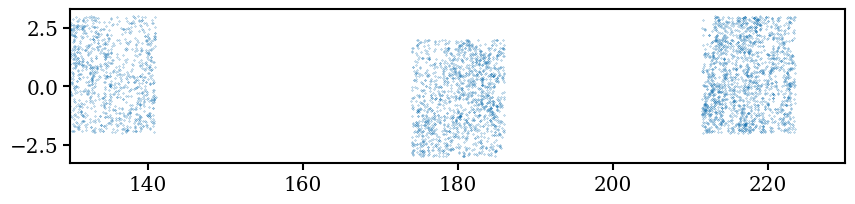

In [9]:
plt.figure(figsize = (10,2))
plt.scatter(tot_cat_slice_gama["RA"], tot_cat_slice_gama["DEC"],s=0.05)
plt.xlim([130,230])


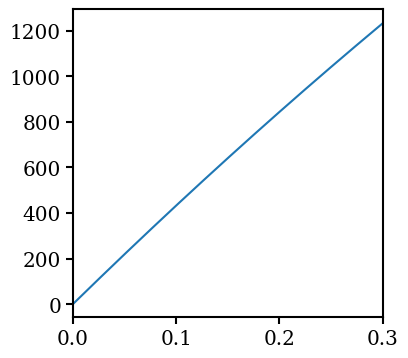

In [10]:
zmax = 0.3

zgrid = np.linspace(0.001,zmax,1000)

cmov_dist = Planck18.comoving_distance(zgrid)

from scipy.interpolate import UnivariateSpline

spl_z = UnivariateSpline( cmov_dist, zgrid, s=0.)

plt.figure(figsize = (4,4))
plt.plot(zgrid, cmov_dist)
plt.xlim([0,zmax])
plt.show()

In [11]:
from astropy.table import Table
saga_gals = Table.read('https://sagasurvey.org/data/saga-dr3-tableC2.txt', format='ascii.mrt')
print(len(saga_gals))

75704


In [14]:
# saga_gals[ (saga_gals["z"] <  0.01) & (saga_gals["z"] != -1)]

In [15]:
saga_slice_mask = (saga_gals["RAdeg"] < 230) & (saga_gals["RAdeg"] > 130) & (saga_gals["DEdeg"] < 5) & (saga_gals["DEdeg"] > -5) & (saga_gals["z"] != -1) & (saga_gals["z"] < 0.3) & (saga_gals["log(M*)"] < 9.25 )

saga_gals_slice = saga_gals[saga_slice_mask]

print(len(saga_gals_slice))

2010


In [ ]:
title_size = 19
ra_ticks_vals = np.array([130,150, 170, 190, 210, 230])
# ra_ticks_vals = np.array([200, 225, 250])
ra_min = 130
ra_max = 230
pad_val =-15

fig, ax = plt.subplots(1,1,figsize = (8,8),subplot_kw={'projection': 'polar'})

plt.subplots_adjust(wspace = 0.1, hspace = 0.01)
### ALL GALAXIES IN NED-LVS
ra_radians = np.deg2rad(tot_cat_slice["RA"])
ax.scatter(ra_radians, tot_cat_slice["comov_dist"], color = "k", alpha=0.75,s=0.25,rasterized=True)
# Add labels and a colorbar
ax.set_theta_zero_location("S")  # Optional: sets 0° at the bottom (South)
ax.set_theta_direction(-1)       # Optional: clockwise direction for RA
# Set title and labels
# ax.set_title('Galaxy Distribution by Redshift and RA')
ax.set_thetamin(ra_min)   # Min angle in degrees (start of the slice)
ax.set_thetamax(ra_max)
ax.set_rlim(0,600)
# ax.set_rticks([])
# ax.tick_params(which='both', length=10, labelsize )  # radial = 'y' in polar
# ax.set_rlim(0, 0.2)

# Add the label using ax.text()
ax.text(np.deg2rad(110),        # angle in radians
        ax.get_rmax() * 0.5,   # just outside the outermost circle
        "Comoving Distance [Mpc]",
        rotation=-38,
        ha='center',
        va='center',
        fontsize=12)

# ax.grid(ls = "-", color = "r",alpha = 1)
ax.grid(ls = ":", color = "lightgrey",alpha = 0.25)

ra_ticks = np.deg2rad(ra_ticks_vals)
ax.set_xticks(ra_ticks)

plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/desi_slice_plot.png",bbox_inches="tight",dpi=150)
plt.close()

###




In [ ]:
import cmasher as cmr


In [ ]:
# title_size = 19
# ra_ticks_vals = np.array([130,150, 170, 190, 210, 230])
# # ra_ticks_vals = np.array([200, 225, 250])
# ra_min = 130
# ra_max = 230
# pad_val =-15

# fig, ax = plt.subplots(1,1,figsize = (8,8),subplot_kw={'projection': 'polar'})

# plt.subplots_adjust(wspace = 0.1, hspace = 0.01)
# ### ALL GALAXIES IN NED-LVS
# ra_radians = np.deg2rad(tot_cat_slice["RA"])
# ax.scatter(ra_radians, tot_cat_slice["comov_dist"], c = tot_cat_slice["LOGM_SAGA"].data, alpha=0.75,s=0.25,rasterized=True, vmin=7,vmax = 9.25, cmap = cmr.ember)
# # Add labels and a colorbar
# ax.set_theta_zero_location("S")  # Optional: sets 0° at the bottom (South)
# ax.set_theta_direction(-1)       # Optional: clockwise direction for RA
# # Set title and labels
# # ax.set_title('Galaxy Distribution by Redshift and RA')
# ax.set_thetamin(ra_min)   # Min angle in degrees (start of the slice)
# ax.set_thetamax(ra_max)
# ax.set_rlim(0,600)

# # Add the label using ax.text()
# ax.text(np.deg2rad(110),        # angle in radians
#         ax.get_rmax() * 0.5,   # just outside the outermost circle
#         "Comoving Distance [Mpc]",
#         rotation=-38,
#         ha='center',
#         va='center',
#         fontsize=12)

# ax.grid(ls = ":", color = "lightgrey",alpha = 0.25)

# ra_ticks = np.deg2rad(ra_ticks_vals)
# ax.set_xticks(ra_ticks)

# # plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/desi_slice_plot.png",bbox_inches="tight")
# plt.show()

# ###




In [ ]:
# Suppose your Astropy table is called `tab`
samples = tot_cat_slice["SAMPLE"].astype(str)  # Convert from bytes to string if necessary

sample_color_map = {"BGS_BRIGHT" : "#882255", "BGS_FAINT": "#CC6677", "LOWZ":"#DDCC77", "ELG": "#88CCEE" }
sample_color_map.items()

In [ ]:
title_size = 19
ra_ticks_vals = np.array([130,150, 170, 190, 210, 230])
# ra_ticks_vals = np.array([200, 225, 250])
ra_min = 130
ra_max = 230
pad_val =-15

fig, ax = plt.subplots(4,1,figsize = (5,20),subplot_kw={'projection': 'polar'})
plt.subplots_adjust(wspace = 0.075, hspace = -0.6)

plot_ind = 0

# ax = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]  ]
ax = [ax[0], ax[1], ax[2], ax[3]  ]


for sample_name, color in sample_color_map.items():

    mask = samples == sample_name
    
    ra_radians = np.deg2rad(tot_cat_slice[mask]["RA"])

    # ax[plot_ind].set_title(sample_name,fontsize = 13)
    
    # ax[plot_ind].scatter(ra_radians, tot_cat_slice["comov_dist"][mask], alpha=0.75,s=0.1,rasterized=True, color = "k" )
    ax[plot_ind].scatter(ra_radians, tot_cat_slice["comov_dist"][mask], alpha=1,s=0.1,rasterized=True, color = color )
    

    # Add labels and a colorbar
    ax[plot_ind].set_theta_zero_location("S")  # Optional: sets 0° at the bottom (South)
    ax[plot_ind].set_theta_direction(-1)       # Optional: clockwise direction for RA
    # Set title and labels
    # ax.set_title('Galaxy Distribution by Redshift and RA')
    ax[plot_ind].set_thetamin(ra_min)   # Min angle in degrees (start of the slice)
    ax[plot_ind].set_thetamax(ra_max)
    ax[plot_ind].set_rlim(0,600)

    ax[plot_ind].set_yticks([])
    ax[plot_ind].set_xticks([])


    if "BGS_" in sample_name:
        sample_name = sample_name.replace("BGS_", "BGS ")

    ax[plot_ind].text(np.deg2rad(180),        # angle in radians
        ax[plot_ind].get_rmax() * 0.85,   # just outside the outermost circle
        sample_name,
        color = "k",
        rotation=0,
        ha='center',
        va='center',
        fontsize=18)

    # Set radial ticks (e.g., comoving distances)
    # r_ticks_vals = [100, 200, 300, 400, 500, 600]
    
    # ax[plot_ind].set_yticks(r_ticks_vals)           # positions of radial ticks
    # ax[plot_ind].set_yticklabels([])

    # ra_ticks = np.deg2rad(ra_ticks_vals)
    # ax[plot_ind].set_xticks(ra_ticks)
    

    plot_ind += 1

# plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/desi_sample_slice_plot.png",dpi=150)
plt.close()
    

In [ ]:

fig, ax = plt.subplots(1,1,figsize = (8,8),subplot_kw={'projection': 'polar'})

plt.subplots_adjust(wspace = 0.1, hspace = 0.01)
ra_radians = np.deg2rad(tot_cat_slice_sdss["RA"])
ax.scatter(ra_radians, tot_cat_slice_sdss["comov_dist"], color = "k", alpha=0.75,s=0.5,rasterized=True)
# Add labels and a colorbar
ax.set_theta_zero_location("S")  # Optional: sets 0° at the bottom (South)
ax.set_theta_direction(-1)       # Optional: clockwise direction for RA
# Set title and labels
# ax.set_title('Galaxy Distribution by Redshift and RA')
ax.set_thetamin(ra_min)   # Min angle in degrees (start of the slice)
ax.set_thetamax(ra_max)
ax.set_rlim(0,600)

ax.text(np.deg2rad(160),        # angle in radians
        ax.get_rmax() * 0.8,   # just outside the outermost circle
        "SDSS-like",
        color = "k",
        rotation=0,
        ha='center',
        va='center',
        fontsize=25)

# ax.set_theta_zero_location("N")  # Zero degrees at the top (North)
# ax.set_theta_direction(-1)       # Clockwise

ax.grid(ls = ":", color = "lightgrey",alpha = 0.5)
ra_ticks = np.deg2rad(ra_ticks_vals)
ax.set_xticks(ra_ticks)
plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/sdss_like_slice_plot.png",bbox_inches="tight",dpi=150)
plt.show()


In [ ]:

fig, ax = plt.subplots(1,1,figsize = (8,8),subplot_kw={'projection': 'polar'})

plt.subplots_adjust(wspace = 0.1, hspace = 0.01)
ra_radians = np.deg2rad(tot_cat_slice_gama["RA"])
ax.scatter(ra_radians, tot_cat_slice_gama["comov_dist"], color = "k", alpha=0.75,s=0.5,rasterized=True)
# Add labels and a colorbar
ax.set_theta_zero_location("S")  # Optional: sets 0° at the bottom (South)
ax.set_theta_direction(-1)       # Optional: clockwise direction for RA
# Set title and labels
# ax.set_title('Galaxy Distribution by Redshift and RA')
ax.set_thetamin(ra_min)   # Min angle in degrees (start of the slice)
ax.set_thetamax(ra_max)
ax.set_rlim(0,600)

ax.text(np.deg2rad(155),        # angle in radians
        ax.get_rmax() * 0.8,   # just outside the outermost circle
        "GAMA-like",
        color = "k",
        rotation=0,
        ha='center',
        va='center',
        fontsize=25)

ax.grid(ls = ":", color = "lightgrey",alpha = 0.5)
ra_ticks = np.deg2rad(ra_ticks_vals)
ax.set_xticks(ra_ticks)
plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/gama_like_slice_plot.png",bbox_inches="tight",dpi=150)
plt.show()


In [ ]:
saga_gals_slice["comov_dist"] = Planck18.comoving_distance(saga_gals_slice["z"]).data


In [ ]:

fig, ax = plt.subplots(1,1,figsize = (8,8),subplot_kw={'projection': 'polar'})

plt.subplots_adjust(wspace = 0.1, hspace = 0.01)
ra_radians = np.deg2rad(saga_gals_slice["RAdeg"])
ax.scatter(ra_radians, saga_gals_slice["comov_dist"], color = "k", alpha=0.75,s=0.5,rasterized=True)
# Add labels and a colorbar
ax.set_theta_zero_location("S")  # Optional: sets 0° at the bottom (South)
ax.set_theta_direction(-1)       # Optional: clockwise direction for RA
# Set title and labels
# ax.set_title('Galaxy Distribution by Redshift and RA')
ax.set_thetamin(ra_min)   # Min angle in degrees (start of the slice)
ax.set_thetamax(ra_max)
ax.set_rlim(0,600)

# Parameters
r_max_shade = 40  # Up to what radius to shade
n_points = 500     # Resolution of the fill
theta1 = np.deg2rad(ra_min)
theta2 = np.deg2rad(ra_max)
theta = np.linspace(theta1, theta2, n_points)

# Create a filled sector
r_inner = np.zeros_like(theta)
r_outer = np.full_like(theta, r_max_shade)

# Fill from center to outer radius
ax.fill(np.concatenate([theta, theta[::-1]]),
        np.concatenate([r_inner, r_outer[::-1]]),
        color='green', alpha=0.5, zorder=0)

ax.text(np.deg2rad(160),        # angle in radians
        ax.get_rmax() * 0.2,   # just outside the outermost circle
        "SAGA",
        color = "green",
        alpha = 1,
        rotation=-70,
        ha='center',
        va='center',
        fontsize=23)


ax.text(np.deg2rad(152),        # angle in radians
        ax.get_rmax() * 0.7,   # just outside the outermost circle
        "SAGA-bg DR3",
        color = "k",
        rotation=0,
        ha='center',
        va='center',
        fontsize=25)

###

ax.grid(ls = ":", color = "lightgrey",alpha = 0.5)
ra_ticks = np.deg2rad(ra_ticks_vals)
ax.set_xticks(ra_ticks)
plt.savefig("/global/homes/v/virajvm/DESI2_LOWZ/quenched_fracs_nbs/paper_plots/saga_bg_like_slice_plot.png",bbox_inches="tight",dpi=150)
plt.show()

